In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from statistics import stdev
from sklearn.neighbors import KernelDensity
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

# Tarea 4
### Gaussian Mixing, Método KDE, K-Means

**Para este laboratorio se utilizan datos relacionados con Apache Point Observatory Galactic Evolution Experiment**  
**Para más información revisar: https://www.sdss.org/dr12/irspec/**

#### Métodos Númericos para la Ciencia y la Ingeniería

#### Victor Faraggi

### Procesamiento de Datos

Antes de enfrentar los problemas de este laboratorio, se abre el archivo dado y se almacena en un *DataFrame* de *Pandas* para facilitar su estudio.

Además, se imprime la información del *DataFrame* para saber el *dtype* para índice y columna, si es que hay valores nulos, etc...

In [2]:
apogee = fits.open('apogee.fits')
apogee.info()

X = apogee[1].data
X = np.array(X).byteswap().newbyteorder() 

df = pd.DataFrame(X)
df.info()

Filename: apogee.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (4325,)   uint8   
  1  Joined        1 BinTableHDU     78   21700R x 27C   [18A, E, E, E, E, E, E, D, D, D, D, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D]   
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21700 entries, 0 to 21699
Data columns (total 27 columns):
APOGEE_ID         21700 non-null object
J                 21700 non-null float32
J_ERR             21700 non-null float32
H                 21700 non-null float32
H_ERR             21700 non-null float32
K                 21700 non-null float32
K_ERR             21700 non-null float32
RA_APO            21700 non-null float64
DEC_APO           21700 non-null float64
GLON              21700 non-null float64
GLAT              21700 non-null float64
TEFF              21700 non-null float32
TEFF_ERR          21700 non-null float32
LOGG              21700 non-null float32
LOGG_ERR          21700 non-n

In [3]:
df.head()

,APOGEE_ID,J,J_ERR,H,H_ERR,K,K_ERR,RA_APO,DEC_APO,GLON,...,ALPHA_M,ALPHA_M_ERR,FE_H,FE_H_ERR,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error
0,b'2M00000662+7528598',9.435,0.027,9.268,0.030,9.216,0.022,0.027622,75.483292,119.657401,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,2.204819,0.427769,32.556320,1.254143,8.990412,1.135909
1,b'2M00001687+5903034',10.062,0.024,9.926,0.025,9.935,0.022,0.070298,59.050957,116.385000,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,2.006050,0.590009,-19.780499,1.338072,-10.981126,0.777774
2,b'2M00001877+5938132',10.065,0.022,10.008,0.028,9.992,0.022,0.078214,59.637016,116.504682,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,1.071401,0.314840,-5.170034,0.969724,-0.954983,0.719485
3,b'2M00002012+5612368',8.110,0.024,7.561,0.027,7.430,0.021,0.083874,56.210224,115.829107,...,0.006614,0.011832,0.099308,0.026246,1.270448,0.339426,0.241290,0.816010,-1.719587,0.501713
4,b'2M00002021+6302567',8.404,0.030,7.844,0.046,7.653,0.024,0.084227,63.049103,117.179533,...,0.010962,0.013568,-0.083574,0.028321,1.639909,0.285941,-7.337902,0.755282,1.079486,0.858307


### P1 Gaussian Mixing

https://scikit-learn.org/stable/modules/mixture.html

mejor ajuste bi-dimensional --> gaussian mixing

Determine los valores de los parametros del modelo que maximiza la ”likelihood”. 

Determine el numero de Gaussianas que mejor ajusta los datos.

Se recuperan las variables que que nos interesa graficar:

In [4]:
alpha = df.ALPHA_M
fe = df.FE_H

print("Alpha_M tiene ",alpha[alpha == -9999.000000].count(),"valores inexistentes")
print("Fe_H tiene ",fe[fe == -9999.000000].count(),"valores inexistentes")

Alpha_M tiene  9058 valores inexistentes
Fe_H tiene  9069 valores inexistentes


In [5]:
new_df = df[['ALPHA_M', 'FE_H']]
new_df.head()

,ALPHA_M,FE_H
0,-9999.000000,-9999.000000
1,-9999.000000,-9999.000000
2,-9999.000000,-9999.000000
3,0.006614,0.099308
4,0.010962,-0.083574


Sabemos que los datos iguales a -9999 equivalen a nulos (inexistentes).

Así, eliminamos los valores inexistentes:

In [6]:
new_df = new_df[(new_df.ALPHA_M != -9999.000000)]
new_df = new_df[(new_df.FE_H != -9999.000000)]
new_df.head()

,ALPHA_M,FE_H
3,0.006614,0.099308
4,0.010962,-0.083574
6,0.003648,-0.016928
7,0.069345,-0.425061
9,0.018490,-0.057823


Verificamos que no hayan valores inexistentes:

In [7]:
alpha = new_df.ALPHA_M
fe = new_df.FE_H

print("Alpha_M tiene ",alpha[alpha == -9999.000000].count(),"valores inexistentes")
print("Fe_H tiene ",fe[fe == -9999.000000].count(),"valores inexistentes")

Alpha_M tiene  0 valores inexistentes
Fe_H tiene  0 valores inexistentes


Se ordenan con respecto a $[\alpha / M]$:

In [8]:
new_df = new_df.sort_values(by=['ALPHA_M'])
new_df.head()

,ALPHA_M,FE_H
14222,-0.462594,-1.470852
1140,-0.438475,-1.351293
11283,-0.343066,-0.615241
10528,-0.259370,-0.650824
15441,-0.253637,-0.062779


Informaciones varías sobre el *DataFrame* final:

In [9]:
print("Cantidad de valores: ", len(new_df.index))
print()
print("Valor máximo de [α/M]: ", new_df.ALPHA_M.max())
print("Valor máximo de [Fe/H]: ", new_df.FE_H.max())
print()
print("Valor mínimo de [α/M]: ", new_df.ALPHA_M.min())
print("Valor mínimo de [Fe/H]: ", new_df.FE_H.min())

Cantidad de valores:  12631

Valor máximo de [α/M]:  0.74588686
Valor máximo de [Fe/H]:  0.4747159

Valor mínimo de [α/M]:  -0.46259406
Valor mínimo de [Fe/H]:  -2.553055


Se grafica $[α/M]$ versus $[Fe/H]$:

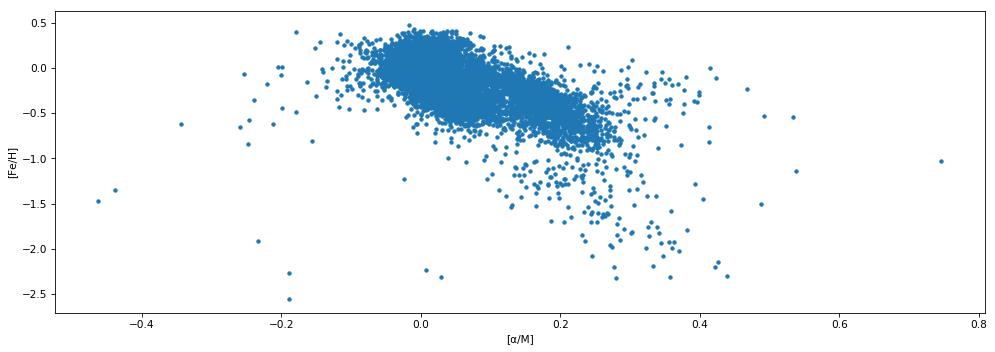

In [10]:
fig = plt.figure()
size = fig.get_figwidth(), fig.get_figheight()
fig.dpi = 75.5
fig.set_size_inches(1200/fig.dpi, 400/fig.dpi)
plt.xlabel('[α/M]')
plt.ylabel('[Fe/H]')
plt.scatter(new_df.ALPHA_M,new_df.FE_H, s=10)

Buscamos eliminar los outliers. Estos son puntos que se alejan de manera significatuva de la muestra.

Para poder detectectarlos se usa el Z-Score:

$$
Z score = \frac{(Valor — Promedia)}{Desviacion estandar}
$$


$$
z = (X — μ) / σ
$$

In [11]:
outliers=[]
def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [12]:
outlier_datapoints = detect_outlier(new_df.FE_H)

Se eliminan del dataset:

In [13]:
for i in outlier_datapoints:
    new_df = new_df[(new_df.FE_H != i)]

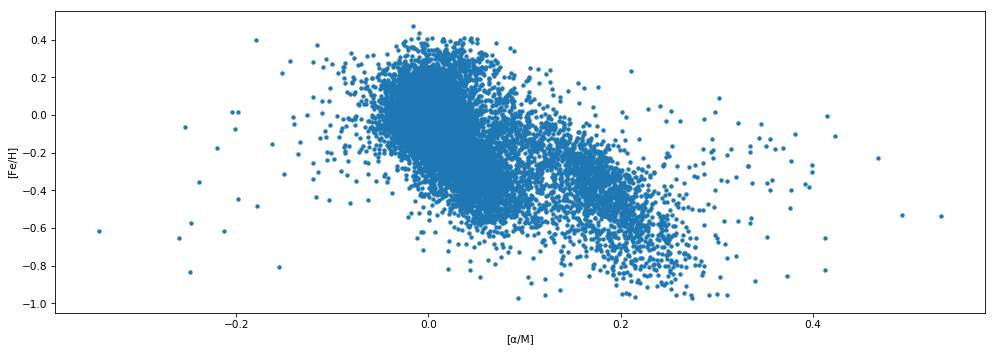

In [14]:
fig = plt.figure()
size = fig.get_figwidth(), fig.get_figheight()
fig.dpi = 75.5
fig.set_size_inches(1200/fig.dpi, 400/fig.dpi)
plt.xlabel('[α/M]')
plt.ylabel('[Fe/H]')
plt.scatter(new_df.ALPHA_M,new_df.FE_H, s=10)

#### Se aplica el método de Gaussian Mixing

Primero, se estima el número de Gaussianas:

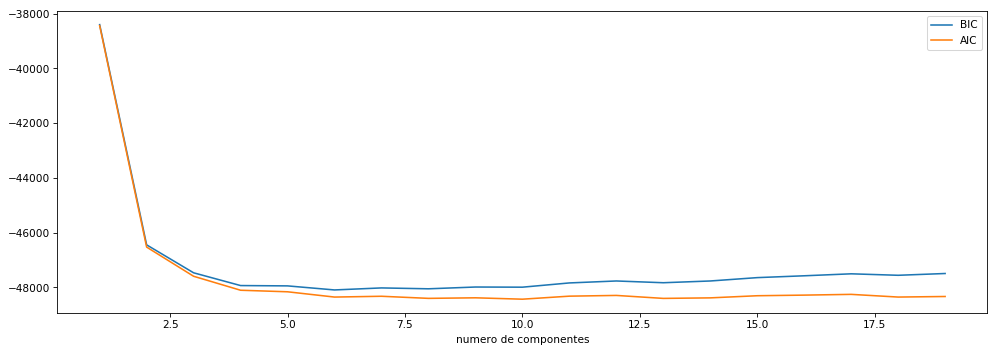

In [15]:
n_estimators = np.arange(1, 20)

clfs = [GaussianMixture(n, covariance_type='full', random_state=0, max_iter=1000).fit(new_df.values) for n in n_estimators]
bics = [clf.bic(new_df) for clf in clfs]
aics = [clf.aic(new_df) for clf in clfs]

fig = plt.figure()
size = fig.get_figwidth(), fig.get_figheight()
fig.dpi = 75.5
fig.set_size_inches(1200/fig.dpi, 400/fig.dpi)

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')

plt.legend(loc='best')
plt.xlabel('numero de componentes');
plt.legend()

Se busca usar el número de componentes más adecuado. Para esto nos referimos al mínimo valor de criterio Bayesiano y al mínimo del criterio Akaike.

In [16]:
valAIC, idxAIC = min((val, idx) for (idx, val) in enumerate(aics))
valBIC, idxBIC = min((val, idx) for (idx, val) in enumerate(bics))


print("El mínimo valor del criterio Bayesiano: ", valBIC, " para ", idxBIC, " componentes.")
print("El mínimo valor del criterio Akaike: ", valAIC, " para ", idxAIC, " componentes.")

El mínimo valor del criterio Bayesiano:  -48090.35125699846  para  5  componentes.
El mínimo valor del criterio Akaike:  -48427.95318290142  para  9  componentes.


Como los mínimos se dan para números de componentes distintos, se busca la menor diferencia:

In [17]:
difBIC = abs(bics[idxAIC] - bics[idxBIC])
difAIC = abs(aics[idxAIC] - aics[idxBIC])
print("La diferencia del criterio Bayesiano entre ",idxBIC, " y ", idxAIC , "componentes: ",difBIC)
print("La diferencia del criterio Akaike entre ", idxBIC, " y ", idxAIC , "componentes: ",difAIC)


La diferencia del criterio Bayesiano entre  5  y  9 componentes:  100.8318553788049
La diferencia del criterio Akaike entre  5  y  9 componentes:  77.51408954936778


Se decide minimizar el criterio Akaike.

In [18]:
componentes = idxAIC
print("Numero de componentes final: ", idxAIC)

Numero de componentes final:  9


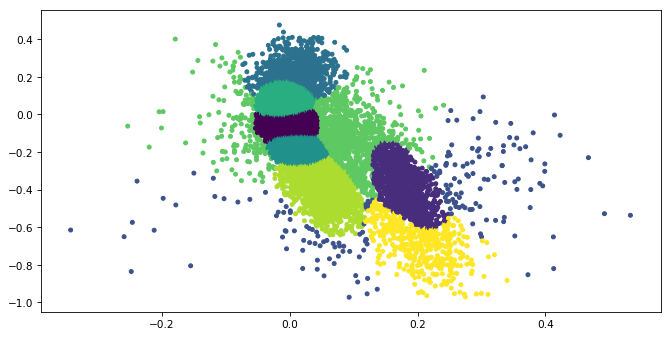

In [19]:
gmm = GaussianMixture(idxAIC, covariance_type="full").fit(new_df)
labels = gmm.predict(new_df)

fig = plt.figure()
size = fig.get_figwidth(), fig.get_figheight()
fig.dpi = 75.5
fig.set_size_inches(800/fig.dpi, 400/fig.dpi)

plt.scatter(new_df.ALPHA_M,new_df.FE_H, c=labels, s=14, cmap='viridis')

Se calcula la probabilidad de cada punto de estar cierto cluster.

El método `predict_proba` retorna una matriz de tamañano `[n_samples, n_clusters]` que mide la probabilidad de que cualquier punto pertenezca al cluster dado.

In [20]:
probs = gmm.predict_proba(new_df)

print(probs[:9].round(3))

[[0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.182 0.    0.    0.    0.818 0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.996 0.    0.    0.    0.004 0.    0.   ]
 [0.    0.    0.499 0.    0.    0.    0.501 0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.009 0.    0.    0.    0.991 0.    0.   ]]


Ahora, se ajusta el tamaño de los puntos gráficados. En ciertas partes se puede apreciar una mejor separación de las componentes.

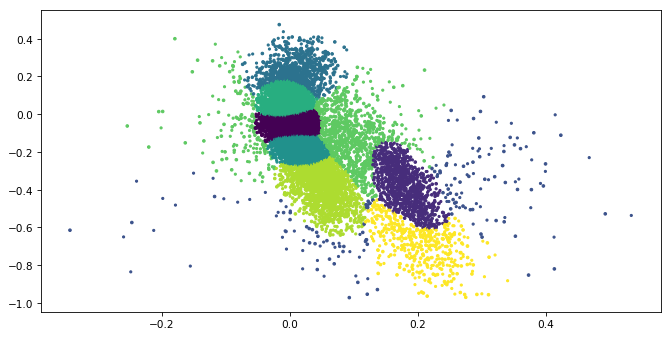

In [21]:
size = 50*probs.max(1)**10

fig = plt.figure()
size = fig.get_figwidth(), fig.get_figheight()
fig.dpi = 75.5
fig.set_size_inches(800/fig.dpi, 400/fig.dpi)

plt.scatter(new_df.ALPHA_M,new_df.FE_H, c=labels, cmap='viridis', s=size);

### P2 Método KDE

Primero se obtienen los valores de interes para este problema:

In [22]:
# Se obtiene el valor de ínteres y se eliminan los valores nulos
eff_list = df.TEFF.tolist()
teff = []
largo = len(eff_list)
for i in range(largo):
    a = eff_list[i]
    if a != -9999.0: ## eliminamos
        teff.append(a)

Se debe implementar el `método KDE con un kernel de Epanechnikov`.

Así, se uede encontrar el mejor ajuste para la distribución de temperatura efectiva $T_{eff}$ en los datos *apogee.fits*.

Finalmente, hay que utilizar el MISE para determinar el $h_{opt}$

Se debe primero calcular el *bandwidth óptimo*. Para esto se usa el MISE:

$$ MISE(h) = E[ISE(h)] \approx \int \frac{1}{Nh}f(x_0)\int K(z)^2dz + {\frac{1}{2}h^2f''(x_0)\int z^2K(z)dz}^2 $$


El ancho de banda óptimo es aquel que minimiza el $MISE(h)$.

Para esto, se toma la expresión anterior y luego se remplazan los valores conocidos.

Así, se obitiene
$$ h^* = 2.345 N^{-0.2} s$$ donde `N` es tamaño de la muestra y `s`: desviación estándar de esta.


Ahora se implementa el `método KDE`:

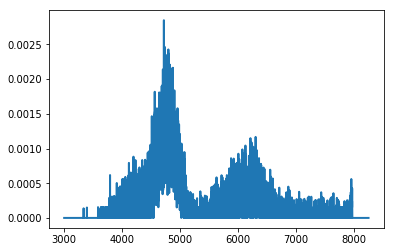

In [23]:
N = len(teff)
s = stdev(teff)

# Se calcula el h_opt
h_opt = 2.345*(1/(N**5))*s

# Se usa reshape para darle las dimensiones necesarias
t_e = np.array(teff)
t_ef_Shaped = t_e.reshape(-1,1)

# Valores de X a usar
x = np.linspace(3000,8250,15000)

kde = KernelDensity(0.35, kernel='epanechnikov').fit(t_ef_Shaped)
densidad = np.exp(kde.score_samples(x[:, None]))

plt.plot(x, densidad, label='Epanechnikov', lw=2)

### P3 K-Means

`K-Means` es un método de agrupamiento, que tiene como objetivo la partición de un conjunto de n observaciones en k grupos en el que cada observación pertenece al grupo cuyo valor medio es más cercano.

El algoritmo utiliza una técnica de refinamiento iterativo.
Así, los pasos de este son los siguientes: 

1. Asigna cada observación al grupo con la media más cercana
2. Calcula los nuevos centroides como el centroide de las observaciones en el grupo.

Se nos pide usar `K-Means` a la muestra dada por $[\alpha / M]$ vs $[FE / H]$. En especial, nos interesamos en los grupos de 2, 3, 4 y 5 clusters.

In [24]:
k = [2,3,4,5,6,7,8,9,10]

resultados = []
sse = {}
sil_score = []
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=10) # clusters
    y_pred = kmeans.fit_predict(new_df) 
    num_iters= kmeans.n_iter_
    sse[i] = kmeans.inertia_ #elbow criterion

    sil = silhouette_score(new_df, kmeans.labels_, random_state= 1)
    sil_score.append(sil)
    res = [kmeans, y_pred, num_iters]
    resultados.append(res)

Para poder decidir cuál es la cantidad de clusters que se deben tener se calcula el `Silhouette Score`.

Este es un criterio de validar el resultado de `K-Means` para la cantidad de clusters dada.

El valor de silueta es una medida de cómo un objeto es a su propio grupo (cohesión) en comparación con otros grupos (separación). La silueta oscila entre −1 y + 1, donde un alto valor indica que el objeto es bien emparejado a su propio grupo y mal emparejado a grupos vecinos. Si la mayoría de los objetos tiene un alto valor, la configuración de clustering es apropiada. Si muchos puntos tienen un valor bajo o negativo, la configuración de clústeres puede tener demasiados o muy pocos racimos.

En pocas palabras, se busca que el valor de `Silhouette Score` sea lo más cercano a 0.

In [25]:
for idx, i in enumerate(sil_score[:4]):
    print("Los silhouette score para", idx+2,"clusters es de:", i)

min_3_sil = np.partition(sil_score[:4], 2)[:3]


Los silhouette score para 2 clusters es de: 0.5340112
Los silhouette score para 3 clusters es de: 0.47121426
Los silhouette score para 4 clusters es de: 0.44189876
Los silhouette score para 5 clusters es de: 0.4206246


Se nota que, en nuestro caso, para más clusters menor es el Silhouette Score.

Entonces, para elegir el `número de clusters óptimo`, se debe tender a elegir el mayor número de clusters posible.

Sin embargo, existe otros criterios de validación como `elbow criterion`.

Este criterio consiste en calcular la suma de la distancia entre cada miembro del cluster y su centroide(`SSE`), al cuadrado. Así, a menor distancia, el cluster será más compacto. Esto en otras palabras quiere decir el cluster parece estar bien definido.

Para elegir el número de clusters con este método, es necesario fijarse en la disminución del `SSE`. Esta siempre tiende a disminuir (más clusters $\implies$ menor distancia a algún centro).

Así, para algún valor, la disminución marginal (entre cada número de cluster) disminuirá de manera *más considerable*. El número de cluster se elige en este punto.

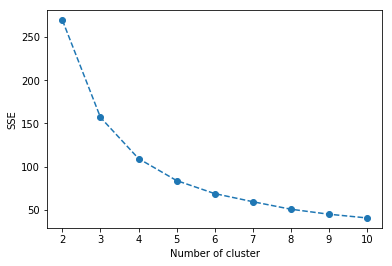

In [26]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'o--')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Como se puede apreciar en el gráfico anterior, la dismución marginal disminuye de manera *más considerable* entre 4 y 5 clusters. 

Es así que teniendo en cuenta el `Silhoutte Score` y `Elbow Criterion` se elige que el número de clusters que mejor representa los datos es de $4$.

A continuación se gráfica esta representación:

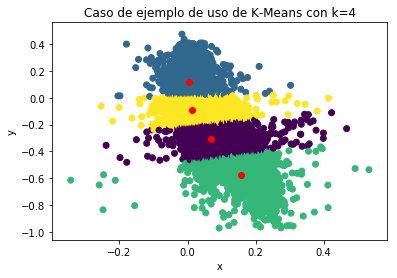

In [27]:
for idx, val in enumerate(resultados): 
    if(idx != 2):
        continue
        
    plt.scatter(new_df.ALPHA_M, new_df.FE_H, c=val[1]) # graficamos los puntos con colores segun y_pred
    for center in val[0].cluster_centers_:
        plt.plot(center[0],center[1],'or') # graficamos los centros
    plt.title('Caso de ejemplo de uso de K-Means con k=%i' %k[idx])
    plt.xlabel('x') # eje x
    plt.ylabel('y') # eje y
    plt.show()
    


Como parte del problema se nos pide probar diferentes valores para la semilla de `K-Means`. Esta semilla está dada por el valor del atributo `random_state`.


Se calculan, a modo de comparación, las distancias relativas entre los centros:

In [28]:
all_dists = []

k = [2,3,4,5]

for random in np.arange(1, 42, 6):
    resultados = []
    dists_relativas = []
    for i in k:
        kmeans = KMeans(n_clusters=i, random_state=random) # clusters
        y_pred = kmeans.fit_predict(new_df) 
        num_iters= kmeans.n_iter_

        res = [kmeans, y_pred, num_iters]
        resultados.append(res)
        
    for idx, val in enumerate(resultados):
        centros = val[0].cluster_centers_

    
        dist_rel = []
        for e in itertools.permutations(centros, 2):
            p_1 = e[0]
            p_2 = e[1]
            dist = np.sqrt((p_1[1] - p_2[1])**2 + (p_1[0] - p_2[0])**2)
            dist_rel.append(dist)

    
        dist_rel = sum(dist_rel)/(len(dist_rel))
    
        resultado = [dist_rel, k[idx]]
        
        print("Para ",resultado[1], " clusters se tiene promedio de distancias entre los clusters de ", resultado[0])
        dists_relativas.append(resultados)
        
        if idx == (len(resultados)-1):
            print("Este estado semilla tomó:", val[2], "iteraciones")
            
    print()


Para  2  clusters se tiene promedio de distancias entre los clusters de  0.38407218802936693
Para  3  clusters se tiene promedio de distancias entre los clusters de  0.38072080807080777
Para  4  clusters se tiene promedio de distancias entre los clusters de  0.3935506495080227
Para  5  clusters se tiene promedio de distancias entre los clusters de  0.4011909948844501
Este estado semilla tomó: 19 iteraciones

Para  2  clusters se tiene promedio de distancias entre los clusters de  0.38407218802936693
Para  3  clusters se tiene promedio de distancias entre los clusters de  0.3820699632373436
Para  4  clusters se tiene promedio de distancias entre los clusters de  0.3935506495080227
Para  5  clusters se tiene promedio de distancias entre los clusters de  0.40094111954910544
Este estado semilla tomó: 21 iteraciones

Para  2  clusters se tiene promedio de distancias entre los clusters de  0.3840218449069465
Para  3  clusters se tiene promedio de distancias entre los clusters de  0.380404084

Como se puede observar, para distintas semillas las distancias se mantienen con una diferencia del orden de $10^{-3}$. Es decir, se mantienen prácticamente iguales.

Sin embargo, hay veces que el método `K-Means` necesita 9 iteraciones y hay otras en las que necesita 21 iteraciones.

Así, se puede decir que si bien la `semilla` puede afectar el rendimiento del método, este tiende a llegar al mismo resultado siempre.